In [1]:
import requests 
from bs4 import BeautifulSoup 
import pandas as pd
import cv2, urllib, numpy as np
import matplotlib.pyplot as plt

In [50]:
class IMDBScraper():
    def __init__(self, page_num):
        self.urls = {}
        self.pages = {}
        self.movie_info = {}
        self.movies_dataframe = pd.DataFrame()
        self.movie_links = {}
        self.page_num = page_num
        
        i = 0 
        for page in range(1,50*page_num + 1,50):
            i += 1 
            self.urls["page_num: {}".format(i)] = 'https://www.imdb.com/search/title/?genres=horror&start={}&explore=title_type,genres&ref_=adv_nxt'.format(page)
            self.pages["page_num: {}".format(i)] = BeautifulSoup(requests.get(self.urls["page_num: {}".format(i)]).text, "html.parser") 
            self.movie_links["page_num: {}".format(i)] = ['https://www.imdb.com' + item.find_all('a')[0].attrs['href'] for item in self.pages["page_num: {}".format(i)].find_all(attrs={'class':'lister-item-header'})]
            

           
    def get_movie_info(self):

        list_of_pages = list(self.pages.values())

        for page_item in list_of_pages:
            movie_data = [item for item in page_item.find_all(attrs={'class':'lister-item mode-advanced'})] 


            for k in range(len(movie_data)):
                movie = str(movie_data[k]).split('\n')



                movie_dict = {}

                for j in range(len(movie)):
                    i = movie[j]    
                    if ('a href="/title/' in i) and ('img' in i): 
                        movie_dict['movie_title'] = i[i.index('img alt=') + 9: i.index('" class=')]
                        movie_dict['movie_image'] = i[i.index('loadlate="https') + 10: i.index('" src="https:')].replace('UX67_CR0,0,67,98_AL_','')
                    elif 'movie_title' not in movie_dict:
                        movie_dict['movie_title'] = None
                        movie_dict['movie_image'] = None 
                    if 'lister-item-year text-muted unbold' in i:
                        movie_dict['release_date'] = i[49 :i.index('</span>')]
                    elif 'release_date' not in movie_dict: 
                        movie_dict['release_date'] = None 
                    if '<span class="certificate' in i: 
                        movie_dict['certificate'] = i[26:i.index('</span>')]
                    elif 'certificate' not in movie_dict: 
                        movie_dict['certificate'] = None 
                    if 'span class="runtime"' in i: 
                        movie_dict['duration'] = i[22:i.index('</span>')]
                    elif 'duration' not in movie_dict: 
                        movie_dict['duration'] = None 
                    if '<span class="genre">' in i:
                        i = movie[j + 1]
                        movie_dict['genre'] = i[:i.index('            </span>')]
                    elif 'genre' not in movie_dict: 
                        movie_dict['genre'] = None 
                    if '<div class="inline-block ratings-imdb-rating" data-value=' in i: 
                        movie_dict['rating'] = i[58:i.index('" name="ir"')]
                    elif 'rating' not in movie_dict: 
                        movie_dict['rating'] = None
                    if '<p class="">' in i:
                        i = movie[j - 1]
                        movie_dict['description'] = i[:i.index('</p>')]
                    elif 'description' not in movie_dict: 
                        movie_dict['description'] = None 
                    if '<p class="sort-num_votes-visible">' in i: 
                        i = movie[j + 2]
                        movie_dict['votes'] = i[18:i.index('" name="nv">')]
                    elif 'votes' not in movie_dict: 
                        movie_dict['votes'] = None



                if ('    Director:' in movie) or ('    Directors:'  in movie):
                    movie_dict['directors'] = ''
                    try:
                        try:
                            movie = movie[movie.index('    Directors:') + 1:movie.index('    Stars:')]
                        except:
                            try:
                                movie = movie[movie.index('    Directors:') + 1:movie.index('    Star:')]
                            except:
                                movie = movie[movie.index('    Directors:') + 1:]


                    except:
                        try:
                            movie = movie[movie.index('    Director:') + 1:movie.index('    Stars:')]
                        except:
                            try:
                                movie = movie[movie.index('    Director:') + 1:movie.index('    Star:')]
                            except:
                                movie = movie[movie.index('    Director:') + 1:]


                    for j in range(len(movie)):
                        i = movie[j]  
                        if '<a href="/name/' in i: 
                            movie_dict['directors'] = ','.join([movie_dict['directors'], i[i.index('/">') + 3: i.index('</a>')]])
                    movie_dict['directors'] = movie_dict['directors'][1:]
                elif 'directors' not in movie_dict:
                    movie_dict['directors'] = None

               #resetting movie list     
                movie = str(movie_data[k]).split('\n')

                if ('    Stars:' in movie) or ('    Star:'  in movie):
                    movie_dict['stars'] = ''
                    try:
                        movie = movie[movie.index('    Stars:') + 1:]
                    except: 
                        movie = movie[movie.index('    Star:') + 1:]
                    for j in range(len(movie)):
                        i = movie[j] 
                        if '<a href="/name/' in i:
                            movie_dict['stars'] = ','.join([movie_dict['stars'], i[i.index('/">') + 3: i.index('</a>')]])
                    movie_dict['stars'] = movie_dict['stars'][1:]
                elif 'stars' not in movie_dict:
                    movie_dict['stars'] = None       
        
                self.movies_dataframe = pd.concat([self.movies_dataframe, pd.DataFrame(movie_dict, index = [k])], axis = 0).reset_index(drop = True)   

    def get_movie_images(self):
        movie_images = [urllib.request.urlopen(url) for url in self.movies_dataframe['movie_image']]
        movie_paths = []
        image_num = 0 
        for image in movie_images: 
            image_array = np.asarray(bytearray(image.read()))
            img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cv2.imwrite('movie_images/' + 'movie_number_' + str(image_num) + '.jpg', img)
            movie_paths.append('movie_images/' + 'movie_number_' + str(image_num) + '.jpg')
            
            image_num += 1 
            
        self.movies_dataframe["movies_local_paths"] = movie_paths
            
        
        
    def save_data(self):
        self.movies_dataframe.to_json('imdb_data.json', indent = 4)

        

                
        

# movie_image = urllib.request.urlopen('https://m.media-amazon.com/images/M/MV5BMzdjNjI5MmYtODhiNS00NTcyLWEzZmUtYzVmODM5YzExNDE3XkEyXkFqcGdeQXVyMTAyMjQ3NzQ1._V1_.jpg')
# image_array = np.asarray(bytearray(movie_image.read()))
# image_array.shape


# img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)       
    

In [51]:
scraper_object = IMDBScraper(1)

scraper_object.get_movie_info()
scraper_object.get_movie_images()



In [52]:
scraper_object.movies_dataframe

,movie_title,movie_image,release_date,certificate,duration,genre,rating,description,votes,directors,stars,movies_local_paths
0,The Last of Us,https://m.media-amazon.com/images/M/MV5BZGUzYT...,(2023– ),15,50 min,"Action, Adventure, Drama",9.2,"After a global pandemic destroys civilization,...",202102,None,"Pedro Pascal,Bella Ramsey,Gabriel Luna,Anna Torv",movie_images/movie_number_0.jpg
1,Knock at the Cabin,https://m.media-amazon.com/images/M/MV5BZTc4Mj...,(2023),15,100 min,"Horror, Mystery, Thriller",6.4,"While vacationing, a girl and her parents are ...",18452,M. Night Shyamalan,"Dave Bautista,Jonathan Groff,Rupert Grint,Nikk...",movie_images/movie_number_1.jpg
2,The Menu,https://m.media-amazon.com/images/M/MV5BMzdjNj...,(2022),15,107 min,"Horror, Thriller",7.2,A young couple travels to a remote island to e...,233146,Mark Mylod,"Ralph Fiennes,Anya Taylor-Joy,Nicholas Hoult,H...",movie_images/movie_number_2.jpg
3,The Walking Dead,https://m.media-amazon.com/images/M/MV5BZmU5NT...,(2010–2022),15,44 min,"Drama, Horror, Thriller",8.1,Sheriff Deputy Rick Grimes wakes up from a com...,1008524,None,"Andrew Lincoln,Norman Reedus,Melissa McBride,L...",movie_images/movie_number_3.jpg
4,Lockwood &amp; Co,https://m.media-amazon.com/images/M/MV5BY2RiOG...,(2023– ),12,44 min,"Action, Adventure, Drama",7.5,"A tiny startup, run by two teenage boys and a ...",11951,None,"Ruby Stokes,Cameron Chapman,Ali Hadji-Heshmati...",movie_images/movie_number_4.jpg
5,M3gan,https://m.media-amazon.com/images/M/MV5BMDk4MT...,(2022),15,102 min,"Horror, Sci-Fi, Thriller",6.4,A robotics engineer at a toy company builds a ...,62925,Gerard Johnstone,"Allison Williams,Violet McGraw,Ronny Chieng,Am...",movie_images/movie_number_5.jpg
6,Viking Wolf,https://m.media-amazon.com/images/M/MV5BYjQ4Nj...,(2022),15,97 min,"Horror, Thriller",5.1,Thale (17) has just moved with her parents to ...,3941,Stig Svendsen,"Liv Mjönes,Elli Rhiannon Müller Osborne,Arthur...",movie_images/movie_number_6.jpg
7,Infinity Pool,https://m.media-amazon.com/images/M/MV5BZDQxZT...,(2023),18,117 min,"Crime, Horror, Mystery",6.4,James and Em Foster are enjoying an all-inclus...,7961,Brandon Cronenberg,"Alexander Skarsgård,Mia Goth,Cleopatra Coleman...",movie_images/movie_number_7.jpg
8,Scream VI,https://m.media-amazon.com/images/M/MV5BYTQ5OT...,(2023),None,123 min,"Horror, Mystery, Thriller",None,"In the next installment, the survivors of the ...",None,"Matt Bettinelli-Olpin,Tyler Gillett","Melissa Barrera,Courteney Cox,Jenna Ortega,Jas...",movie_images/movie_number_8.jpg
9,Stranger Things,https://m.media-amazon.com/images/M/MV5BMDZkYm...,(2016–2024),15,51 min,"Drama, Fantasy, Horror",8.7,"When a young boy disappears, his mother, a pol...",1213281,None,"Millie Bobby Brown,Finn Wolfhard,Winona Ryder,...",movie_images/movie_number_9.jpg


In [53]:
scraper_object.save_data()

In [36]:
temp_page = list(scraper_object.pages.values())[0]

test = ['https://www.imdb.com' + item.find_all('a')[0].attrs['href'] for item in temp_page.find_all(attrs={'class':'lister-item-header'})]


print(test)


['https://www.imdb.com/title/tt3581920/', 'https://www.imdb.com/title/tt15679400/', 'https://www.imdb.com/title/tt9764362/', 'https://www.imdb.com/title/tt1520211/', 'https://www.imdb.com/title/tt13802576/', 'https://www.imdb.com/title/tt8760708/', 'https://www.imdb.com/title/tt13051810/', 'https://www.imdb.com/title/tt10365998/', 'https://www.imdb.com/title/tt17663992/', 'https://www.imdb.com/title/tt4574334/', 'https://www.imdb.com/title/tt14138650/', 'https://www.imdb.com/title/tt0460681/', 'https://www.imdb.com/title/tt13560574/', 'https://www.imdb.com/title/tt19623240/', 'https://www.imdb.com/title/tt15428778/', 'https://www.imdb.com/title/tt15487922/', 'https://www.imdb.com/title/tt13280054/', 'https://www.imdb.com/title/tt2560140/', 'https://www.imdb.com/title/tt8068860/', 'https://www.imdb.com/title/tt21307994/', 'https://www.imdb.com/title/tt2140553/', 'https://www.imdb.com/title/tt11041332/', 'https://www.imdb.com/title/tt1844624/', 'https://www.imdb.com/title/tt15791034/', '

In [37]:
test_link = BeautifulSoup(requests.get('https://www.imdb.com/title/tt1520211/?ref_=adv_li_tt').text, "html.parser")
print(test_link)

<html>
<head><title>403 Forbidden</title></head>
<body>
<center><h1>403 Forbidden</h1></center>
</body>
</html>



In [38]:
movie_data = [item for item in temp_page.find_all(attrs={'class':'lister-item mode-advanced'})] 
movie = str(movie_data[1]).split('\n')
movie



['<div class="lister-item mode-advanced">',
 '<div class="lister-top-right">',
 '<div class="ribbonize" data-caller="filmosearch" data-tconst="tt15679400"></div>',
 '</div>',
 '<div class="lister-item-image float-left">',
 '<a href="/title/tt15679400/"> <img alt="Knock at the Cabin" class="loadlate" data-tconst="tt15679400" height="98" loadlate="https://m.media-amazon.com/images/M/MV5BZTc4MjU0MjMtYTEwNy00YjNlLTk2MGYtMjNlNzFjMmY4MjQ0XkEyXkFqcGdeQXVyODk4OTc3MTY@._V1_UX67_CR0,0,67,98_AL_.jpg" src="https://m.media-amazon.com/images/S/sash/4FyxwxECzL-U1J8.png" width="67"/>',
 '</a> </div>',
 '<div class="lister-item-content">',
 '<h3 class="lister-item-header">',
 '<span class="lister-item-index unbold text-primary">2.</span>',
 '<a href="/title/tt15679400/">Knock at the Cabin</a>',
 '<span class="lister-item-year text-muted unbold">(2023)</span>',
 '</h3>',
 '<p class="text-muted">',
 '<span class="certificate">15</span>',
 '<span class="ghost">|</span>',
 '<span class="runtime">100 min</s

In [39]:
movies_dataframe = pd.DataFrame()

list_of_pages = list(scraper_object.pages.values())

for page_item in list_of_pages:
    movie_data = [item for item in page_item.find_all(attrs={'class':'lister-item mode-advanced'})] 


    for k in range(len(movie_data)):
        movie = str(movie_data[k]).split('\n')



        movie_dict = {}

        for j in range(len(movie)):
            i = movie[j]    
            if ('a href="/title/' in i) and ('img' in i): 
                movie_dict['movie_title'] = i[i.index('img alt=') + 9: i.index('" class=')]
                movie_dict['movie_image'] = i[i.index('loadlate="https') + 10: i.index('" src="https:')].replace('UX67_CR0,0,67,98_AL_','')
            elif 'movie_title' not in movie_dict:
                movie_dict['movie_title'] = None
                movie_dict['movie_image'] = None 
            if 'lister-item-year text-muted unbold' in i:
                movie_dict['release_date'] = i[49 :i.index('</span>')]
            elif 'release_date' not in movie_dict: 
                movie_dict['release_date'] = None 
            if '<span class="certificate' in i: 
                movie_dict['certificate'] = i[26:i.index('</span>')]
            elif 'certificate' not in movie_dict: 
                movie_dict['certificate'] = None 
            if 'span class="runtime"' in i: 
                movie_dict['duration'] = i[22:i.index('</span>')]
            elif 'duration' not in movie_dict: 
                movie_dict['duration'] = None 
            if '<span class="genre">' in i:
                i = movie[j + 1]
                movie_dict['genre'] = i[:i.index('            </span>')]
            elif 'genre' not in movie_dict: 
                movie_dict['genre'] = None 
            if '<div class="inline-block ratings-imdb-rating" data-value=' in i: 
                movie_dict['rating'] = i[58:i.index('" name="ir"')]
            elif 'rating' not in movie_dict: 
                movie_dict['rating'] = None
            if '<p class="">' in i:
                i = movie[j - 1]
                movie_dict['description'] = i[:i.index('</p>')]
            elif 'description' not in movie_dict: 
                movie_dict['description'] = None 
            if '<p class="sort-num_votes-visible">' in i: 
                i = movie[j + 2]
                movie_dict['votes'] = i[18:i.index('" name="nv">')]
            elif 'votes' not in movie_dict: 
                movie_dict['votes'] = None



        if ('    Director:' in movie) or ('    Directors:'  in movie):
            movie_dict['directors'] = ''
            try:
                try:
                    movie = movie[movie.index('    Directors:') + 1:movie.index('    Stars:')]
                except:
                    try:
                        movie = movie[movie.index('    Directors:') + 1:movie.index('    Star:')]
                    except:
                        movie = movie[movie.index('    Directors:') + 1:]
                        
                    
            except:
                try:
                    movie = movie[movie.index('    Director:') + 1:movie.index('    Stars:')]
                except:
                    try:
                        movie = movie[movie.index('    Director:') + 1:movie.index('    Star:')]
                    except:
                        movie = movie[movie.index('    Director:') + 1:]
                        
            
            for j in range(len(movie)):
                i = movie[j]  
                if '<a href="/name/' in i: 
                    movie_dict['directors'] = ','.join([movie_dict['directors'], i[i.index('/">') + 3: i.index('</a>')]])
            movie_dict['directors'] = movie_dict['directors'][1:]
        elif 'directors' not in movie_dict:
            movie_dict['directors'] = None

       #resetting movie list     
        movie = str(movie_data[k]).split('\n')

        if ('    Stars:' in movie) or ('    Star:'  in movie):
            movie_dict['stars'] = ''
            try:
                movie = movie[movie.index('    Stars:') + 1:]
            except: 
                movie = movie[movie.index('    Star:') + 1:]
            for j in range(len(movie)):
                i = movie[j] 
                if '<a href="/name/' in i:
                    movie_dict['stars'] = ','.join([movie_dict['stars'], i[i.index('/">') + 3: i.index('</a>')]])
            movie_dict['stars'] = movie_dict['stars'][1:]
        elif 'stars' not in movie_dict:
            movie_dict['stars'] = None       
  




        movies_dataframe = pd.concat([movies_dataframe, pd.DataFrame(movie_dict, index = [k])], axis = 0).reset_index(drop = True)   


display(movies_dataframe)



,movie_title,movie_image,release_date,certificate,duration,genre,rating,description,votes,directors,stars
0,The Last of Us,https://m.media-amazon.com/images/M/MV5BZGUzYT...,(2023– ),15,50 min,"Action, Adventure, Drama",9.2,"After a global pandemic destroys civilization,...",201995,None,"Pedro Pascal,Bella Ramsey,Gabriel Luna,Anna Torv"
1,Knock at the Cabin,https://m.media-amazon.com/images/M/MV5BZTc4Mj...,(2023),15,100 min,"Horror, Mystery, Thriller",6.4,"While vacationing, a girl and her parents are ...",18434,M. Night Shyamalan,"Dave Bautista,Jonathan Groff,Rupert Grint,Nikk..."
2,The Menu,https://m.media-amazon.com/images/M/MV5BMzdjNj...,(2022),15,107 min,"Horror, Thriller",7.2,A young couple travels to a remote island to e...,233081,Mark Mylod,"Ralph Fiennes,Anya Taylor-Joy,Nicholas Hoult,H..."
3,The Walking Dead,https://m.media-amazon.com/images/M/MV5BZmU5NT...,(2010–2022),15,44 min,"Drama, Horror, Thriller",8.1,Sheriff Deputy Rick Grimes wakes up from a com...,1008514,None,"Andrew Lincoln,Norman Reedus,Melissa McBride,L..."
4,Lockwood &amp; Co,https://m.media-amazon.com/images/M/MV5BY2RiOG...,(2023– ),12,44 min,"Action, Adventure, Drama",7.5,"A tiny startup, run by two teenage boys and a ...",11935,None,"Ruby Stokes,Cameron Chapman,Ali Hadji-Heshmati..."
...,...,...,...,...,...,...,...,...,...,...,...
145,Twin Peaks,https://m.media-amazon.com/images/M/MV5BZWZiNW...,(2017– ),15,60 min,"Crime, Drama, Horror",8.5,Picks up 25 years after the inhabitants of a q...,69336,None,"Kyle MacLachlan,Sheryl Lee,Michael Horse,Chrys..."
146,The Kingdom,https://m.media-amazon.com/images/M/MV5BMjM4ND...,(1994–2022),18,561 min,"Comedy, Drama, Fantasy",8.2,Doctors at an ultramodern hospital in Denmark ...,19305,None,"Ernst-Hugo Järegård,Kirsten Rolffes,Ghita Nørb..."
147,The Platform,https://m.media-amazon.com/images/M/MV5BMzllNm...,(2019),18,94 min,"Horror, Sci-Fi, Thriller",7,A vertical prison with one cell per level. Two...,234124,Galder Gaztelu-Urrutia,"Ivan Massagué,Zorion Eguileor,Antonia San Juan..."
148,Mother!,https://m.media-amazon.com/images/M/MV5BMzc5OD...,(2017),18,121 min,"Drama, Horror, Mystery",6.6,A couple's relationship is tested when uninvit...,231045,Darren Aronofsky,"Jennifer Lawrence,Javier Bardem,Ed Harris,Mich..."


https://m.media-amazon.com/images/M/MV5BMzdjNjI5MmYtODhiNS00NTcyLWEzZmUtYzVmODM5YzExNDE3XkEyXkFqcGdeQXVyMTAyMjQ3NzQ1._V1_.jpg


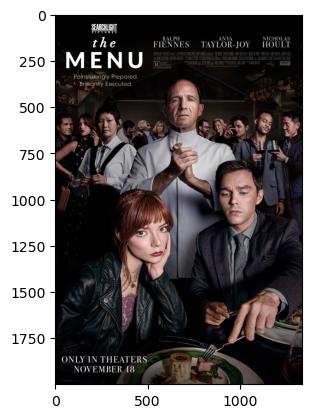

In [42]:
import cv2, urllib, numpy as np
import matplotlib.pyplot as plt
movie_image = urllib.request.urlopen('https://m.media-amazon.com/images/M/MV5BMzdjNjI5MmYtODhiNS00NTcyLWEzZmUtYzVmODM5YzExNDE3XkEyXkFqcGdeQXVyMTAyMjQ3NzQ1._V1_.jpg')
image_array = np.asarray(bytearray(movie_image.read()))
image_array.shape


img = cv2.imdecode(image_array, cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
'https://m.media-amazon.com/images/M/MV5BZDIzYzJhODUtOTU5Ny00NzY5LTg5YmQtOWU4ODBjYjMyMmEzXkEyXkFqcGdeQXVyMTk2OTAzNTI@._V1_.jpg 1080w'
'https://m.media-amazon.com/images/M/MV5BZGUzYTI3M2EtZmM0Yy00NGUyLWI4ODEtN2Q3ZGJlYzhhZjU3XkEyXkFqcGdeQXVyNTM0OTY1OQ@@._V1_UX67_CR0,0,67,98_AL_.jpg'

In [34]:
for link in movies_dataframe.iloc[:,1]:
    print(link)

https://m.media-amazon.com/images/M/MV5BZGUzYTI3M2EtZmM0Yy00NGUyLWI4ODEtN2Q3ZGJlYzhhZjU3XkEyXkFqcGdeQXVyNTM0OTY1OQ@@._V1_UX67_CR0,0,67,98_AL_.jpg
https://m.media-amazon.com/images/M/MV5BZTc4MjU0MjMtYTEwNy00YjNlLTk2MGYtMjNlNzFjMmY4MjQ0XkEyXkFqcGdeQXVyODk4OTc3MTY@._V1_UX67_CR0,0,67,98_AL_.jpg
https://m.media-amazon.com/images/M/MV5BMzdjNjI5MmYtODhiNS00NTcyLWEzZmUtYzVmODM5YzExNDE3XkEyXkFqcGdeQXVyMTAyMjQ3NzQ1._V1_UX67_CR0,0,67,98_AL_.jpg
https://m.media-amazon.com/images/M/MV5BZmU5NTcwNjktODIwMi00ZmZkLTk4ZWUtYzVjZWQ5ZTZjN2RlXkEyXkFqcGdeQXVyMTkxNjUyNQ@@._V1_UX67_CR0,0,67,98_AL_.jpg
https://m.media-amazon.com/images/M/MV5BY2RiOGNmMmYtNmFlOC00MDg2LTk2YTItZWRmMmZjZjc1OGMxXkEyXkFqcGdeQXVyMTYxMDYwMzI2._V1_UY98_CR5,0,67,98_AL_.jpg
https://m.media-amazon.com/images/M/MV5BMDk4MTdhYzEtODk3OS00ZDBjLWFhNTQtMDI2ODdjNzQzZTA3XkEyXkFqcGdeQXVyMjMxOTE0ODA@._V1_UX67_CR0,0,67,98_AL_.jpg
https://m.media-amazon.com/images/M/MV5BYjQ4NjUzYzgtNmEwMy00MGM0LWE1NWQtYzUzNjMwNTY2MmY4XkEyXkFqcGdeQXVyMDMxMTgwOQ@@._V1_UY9

movies_dataframe = pd.concat([self.movies_dataframe, pd.DataFrame(extra_movie_dict,index = [0])], axis = 0